# Visuals

The purpose of this notebook is to explore the data visually. After merging the data. We want to explores the features vs wnv present and mosquitoes count. Since we are trying to predict when there are wnv present. We want to see if there are any relationships with the weather data and the mosquitoes life cycle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import pickle
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../data/train_weather_merged_wnvpresent_nummosquitos.csv')

# setting the date as a datetime series for plot
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

# Adding the weeks for evaluation
df['week'] = df.index.week
df['weekday_name'] = df.index.weekday_name

In [4]:
# Extracting the years from the data frame
[year for year in df.index.year.value_counts().sort_index().keys()]

[2007, 2009, 2011, 2013]

In [18]:
# Creating a dataframe table of the number of mosquitoes for each month
df.groupby(by=['month']).count()[['nummosquitos']].rename(
    index={5: 'May',6: 'June',7: 'July',8: 'August',9: 'September',10: 'October'},
    columns={'month': 'Months', 'nummosquitos': 'Num of Mosquitoes'})

,Num of Mosquitoes
month,
May,84
June,1478
July,2606
August,3751
September,2218
October,276


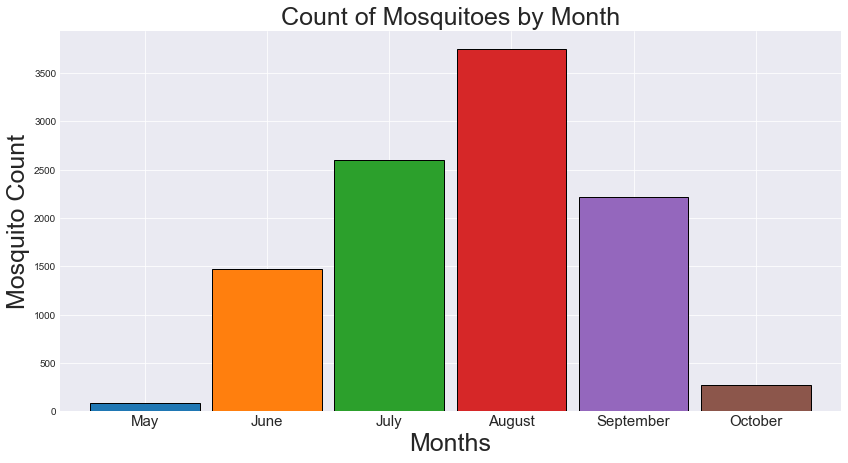

In [19]:
fig, ax = plt.subplots(figsize=(14, 7))
df.groupby(by=['month']).count().unstack()[['nummosquitos']].plot(kind='bar', ax=ax, width=.9, ec='k')
ax.set_ylabel('Mosquito Count', fontsize=25)
ax.set_xlabel('Months', fontsize=25)
ax.set_xticklabels(['May', 'June', 'July', 'August', 'September', 'October'], rotation=0, fontsize=15)
ax.set_title('Count of Mosquitoes by Month', fontsize=25);

plt.savefig('../plots/count_mosquitoes_by_month.png')

# This plot shows that August has the highest occurance of mosquitoes

In [20]:
# Creating a table for the wnv present vs the months
df.groupby(by=['month']).sum()[['wnvpresent']].rename(
    index={5: 'May',6: 'June',7: 'July',8: 'August',9: 'September',10: 'October'},
    columns={'month': 'Months', 'wnvpresent': 'WNV Present'})

,WNV Present
month,
May,0
June,1
July,46
August,377
September,125
October,2


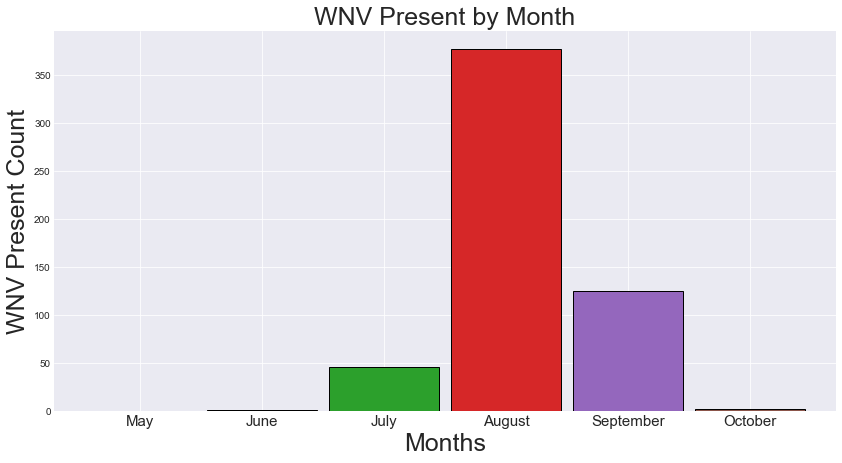

In [21]:
fig, ax = plt.subplots(figsize=(14, 7))
df.groupby(by=['month']).sum().unstack()[['wnvpresent']].plot(kind='bar', ax=ax, width=.9, ec='k')
ax.set_ylabel('WNV Present Count', fontsize=25)
ax.set_xlabel('Months', fontsize=25)
ax.set_xticklabels(['May', 'June', 'July', 'August', 'September', 'October'], rotation=0, fontsize=15)
ax.set_title('WNV Present by Month', fontsize=25);

plt.savefig('../plots/count_wnvpresent_by_month.png')

# This plot shows by far August is the month to check for WNV 

In [22]:
df.groupby(by=['month','species']).sum().unstack()[['nummosquitos']]

#This dataframe shows the numbers for the graphs below. It's shows the # of Mosq.

nummosquitos                                                    
species  culex other culex pipiens culex pipiens/restuans culex restuans
month                                                                   
5                NaN           4.0                  114.0          112.0
6               75.0         235.0                 8717.0         6753.0
7              128.0        4106.0                20913.0        12101.0
8              341.0       29728.0                24992.0         2975.0
9               92.0        9707.0                10012.0         1218.0
10              24.0         877.0                  962.0           55.0

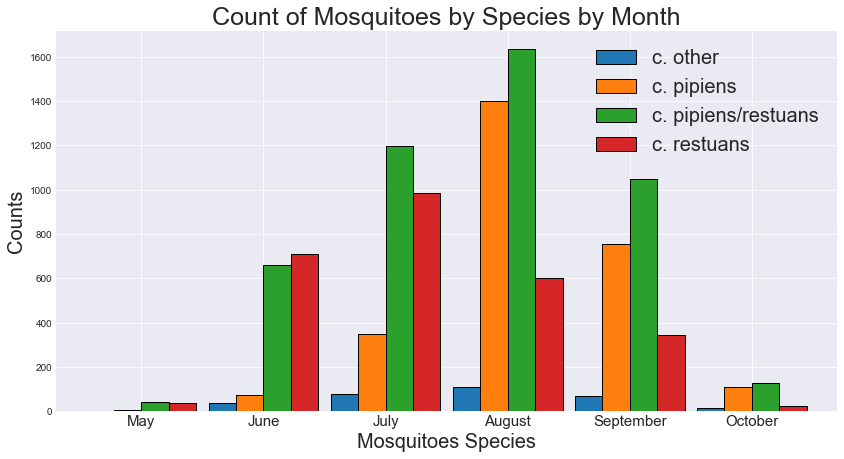

In [23]:
fig, ax = plt.subplots(figsize=(14, 7))
df.groupby(by=['month','species']).count().unstack()[['nummosquitos']].plot(kind='bar', ax=ax, width=.9, ec='k')
ax.set_ylabel('Counts', fontsize=20)
ax.set_xlabel('Mosquitoes Species', fontsize=20)
ax.set_xticklabels(['May', 'June', 'July', 'August', 'September', 'October'], rotation=0, fontsize=15)
ax.legend(['c. other', 'c. pipiens', 'c. pipiens/restuans', 'c. restuans'], fontsize=20)
ax.set_title('Count of Mosquitoes by Species by Month', fontsize=25);

plt.savefig('../plots/count_types_mosquitoes_by_month.png')

# The plot below is broken down by month of the 4 species on mosquitoes vs the count

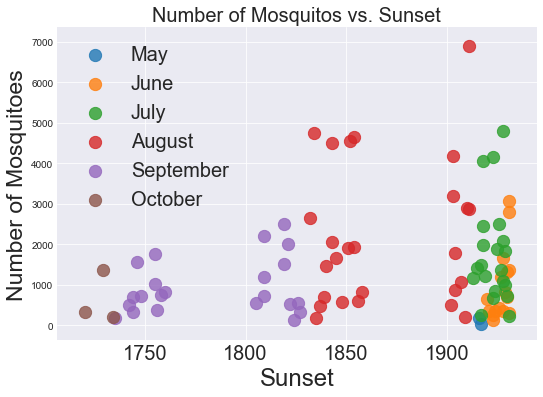

In [24]:
sunset_vs_nummosquitos_df = df[['sunset', 'nummosquitos', 'year', 'month']].groupby(
    by=['year', 'month', 'sunset']).sum()

sunset_vs_nummosquitos_df.reset_index(inplace=True)

sns.lmplot(data=sunset_vs_nummosquitos_df, y='nummosquitos', x='sunset', 
           hue='month', fit_reg=False,
          size=5, aspect=1.5, scatter_kws={"s": 150}, legend=False)

plt.legend(['May', 'June', 'July', 'August', 'September', 'October'], loc='best', fontsize=20)
plt.xlabel('Sunset', fontsize=24)
plt.ylabel('Number of Mosquitoes', fontsize=23)
plt.xticks(fontsize=20)
plt.title('Number of Mosquitos vs. Sunset', fontsize=20)

plt.savefig('../plots/mosquitoes_vs_sunset_on_months_all_years.png')

# This figure shows the # of mosquitoes vs the sunset. 
# Note the gaps from 1760 - 1800 and 1860 - 1900
# This is due to the sunset column was set as an integer type. T
# There are no times for 61, 62, etc.. to 99 seconds
# In the next code block I will show you how to fix this issue

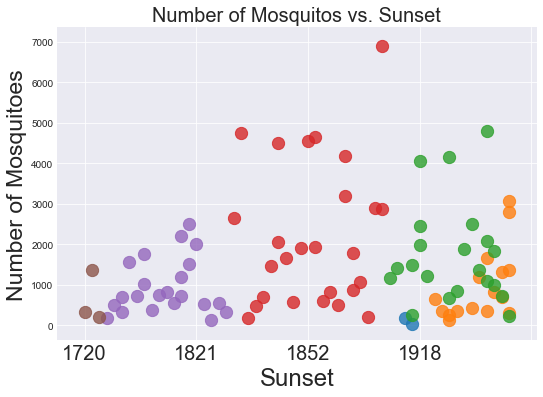

In [173]:
sunset_sorted_df = sunset_vs_nummosquitos_df.sort_values(by='sunset')
sunset_sorted_df['sunset'] = sunset_sorted_df.sunset.astype(str)
sunset_sorted_df.reset_index(inplace=True)

sns.lmplot(data=sunset_sorted_df, y='nummosquitos', x='sunset', 
           hue='month', fit_reg=False,
          size=5, aspect=1.5, scatter_kws={"s": 150}, legend=False)
plt.xlabel('Sunset', fontsize=24)
plt.ylabel('Number of Mosquitoes', fontsize=23)
plt.xticks(np.arange(0, 70, step=15), fontsize=20);
plt.title('Number of Mosquitos vs. Sunset', fontsize=20);

# This plot shows Sunset VS. Num of Mosquitoes separated by month in colors
# Inorder to fix this problem, I first sorted the values for the sunset so it's in order
# Then I save the data to a new dataframe and change the type to a string so it's an object
# Then you can graph the data without having a gap in the time without turning the
# data to a datetime series

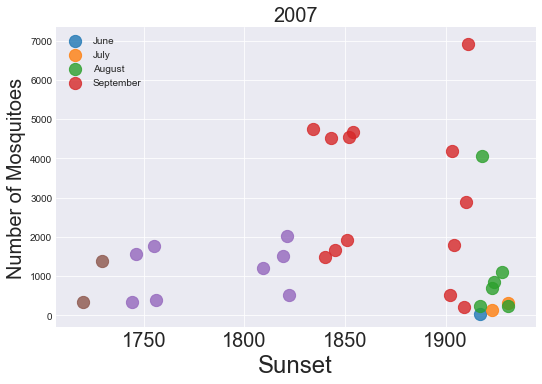

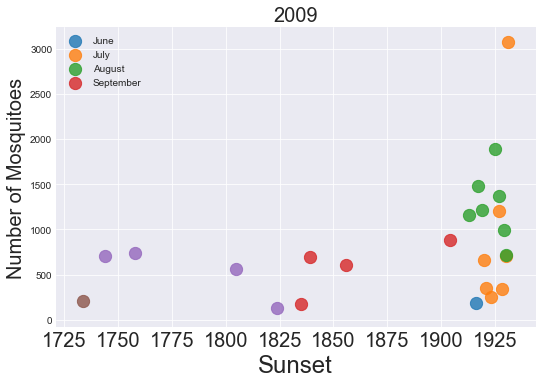

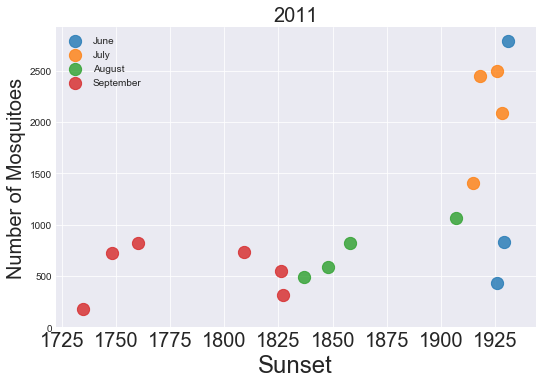

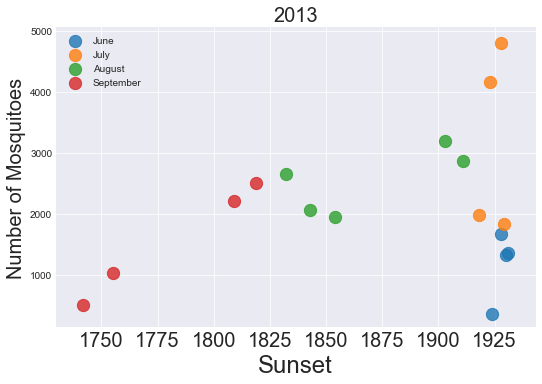

In [25]:
for year in [2007, 2009, 2011, 2013]:
    sns.lmplot(data=sunset_vs_nummosquitos_df[sunset_vs_nummosquitos_df.year == year], 
               y='nummosquitos', x='sunset', col='year', hue='month', fit_reg=False, 
               size=5, aspect=1.5, scatter_kws={"s": 150}, legend=False);

    plt.xlabel('Sunset', fontsize=24)
    plt.ylabel('Number of Mosquitoes', fontsize=20);
    plt.legend(['June', 'July', 'August', 'September'], loc='upper left')
    plt.xticks(fontsize=20)
    plt.title(year, fontsize=20)

    plt.savefig(f'../plots/mosquitoes_vs_sunset_on_months_{year}.png')
    
# The for-Loop above shows the Sunset VS # of Mosquitoes in the training data years
# The trend is the later the sunset the more # of mosquitoes 

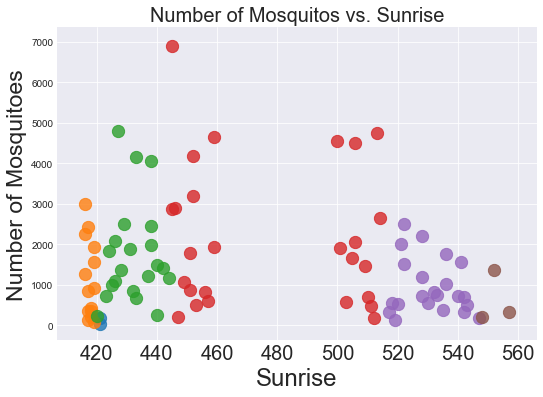

In [130]:
sunrise_vs_nummosquitos_df = df[['sunrise', 'nummosquitos', 'year', 'month']].groupby(
    by=['year', 'month', 'sunrise']).sum()

sunrise_vs_nummosquitos_df.reset_index(inplace=True)

sns.lmplot(data=sunrise_vs_nummosquitos_df, y='nummosquitos', x='sunrise', 
           hue='month', fit_reg=False,
          size=5, aspect=1.5, scatter_kws={"s": 150}, legend=False)

# plt.legend(['May', 'June', 'July', 'August', 'September', 'October'], loc='best', fontsize=10)
plt.xlabel('Sunrise', fontsize=24)
plt.ylabel('Number of Mosquitoes', fontsize=23)
plt.xticks(fontsize=20)
plt.title('Number of Mosquitos vs. Sunrise', fontsize=20)

plt.savefig('../plots/mosquitoes_vs_sunrise_on_months_all_years.png')

# 1. This graph shows the earlier the sunrises tend to have higher number of mosquitoes.
# 2. The Sunrise is also related to the month 
# 3. There's a gap in the middle because the value for sunrise was a float but was converted to a 
#    number instead of timeseries

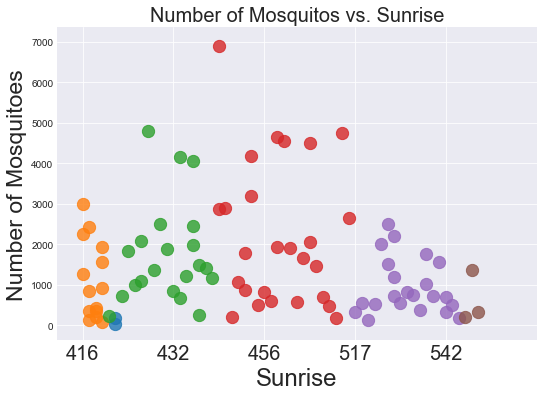

In [177]:
sunrise_sorted_df = sunrise_vs_nummosquitos_df.sort_values(by='sunrise')
sunrise_sorted_df['sunrise'] = sunrise_sorted_df.sunrise.astype(str)
sunrise_sorted_df.reset_index(inplace=True)

sns.lmplot(data=sunrise_sorted_df, y='nummosquitos', x='sunrise', 
           hue='month', fit_reg=False,
          size=5, aspect=1.5, scatter_kws={"s": 150}, legend=False)
plt.xlabel('Sunrise', fontsize=24)
plt.ylabel('Number of Mosquitoes', fontsize=23)
plt.xticks(np.arange(0, 80, step=14), fontsize=20);
plt.title('Number of Mosquitos vs. Sunrise', fontsize=20);

# Similarity to the sunset data, the sunrise had a gap in the time above.
# This was removed once we converted the data back to a string type

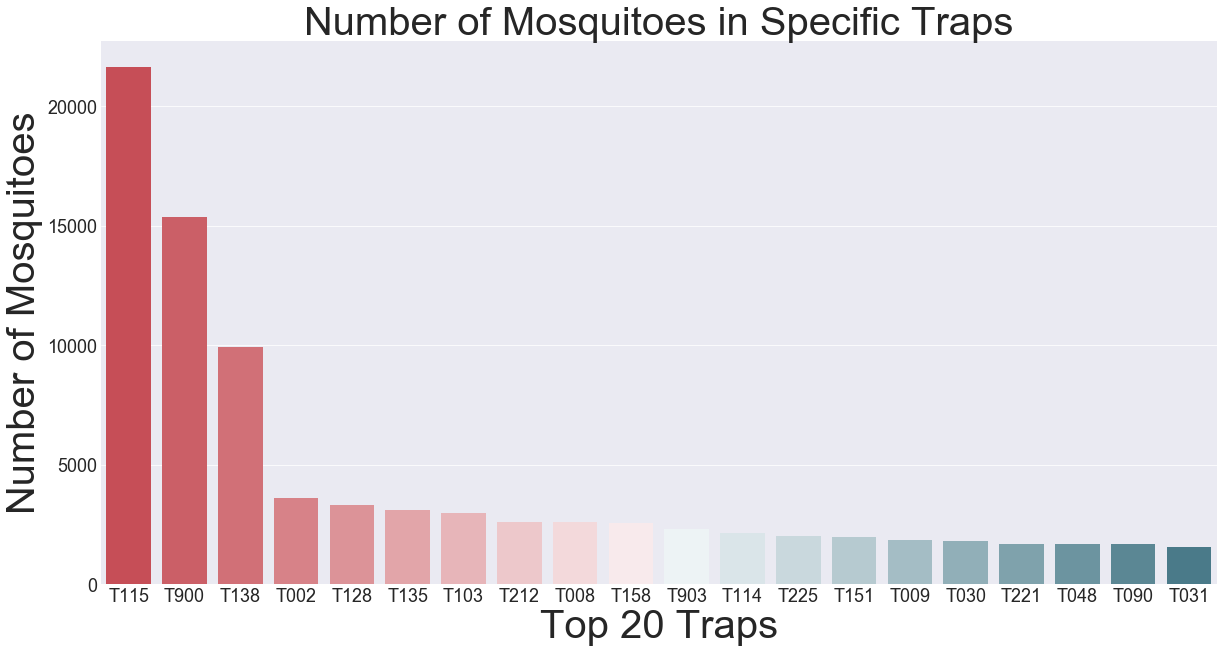

In [49]:
# Creating the dataframe of traps with nummosquitoes and wnvpresent
nummos_wnv_vs_trap_df = df.groupby(by='trap').sum()[['nummosquitos', 'wnvpresent']].sort_values(by='nummosquitos', ascending=False)
mosquitoes_wnv_vs_traps_top20 = nummos_wnv_vs_trap_df.head(20)
mosquitoes_wnv_vs_traps_top20.reset_index(inplace=True)

f, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=mosquitoes_wnv_vs_traps_top20,
           x=mosquitoes_wnv_vs_traps_top20.trap,
           y=mosquitoes_wnv_vs_traps_top20.nummosquitos,
           ax=ax, palette=sns.diverging_palette(10, 220, n=20), );
ax.tick_params(labelsize=18)
ax.set_ylabel('Number of Mosquitoes', fontsize=40)
ax.set_xlabel('Top 20 Traps', fontsize=40)
ax.set_title('Number of Mosquitoes in Specific Traps', fontsize=40);

plt.savefig('../plots/number_of_mosquitoes_in_specific_traps.png')

# This plot shows the top 20 traps with mosquitoes

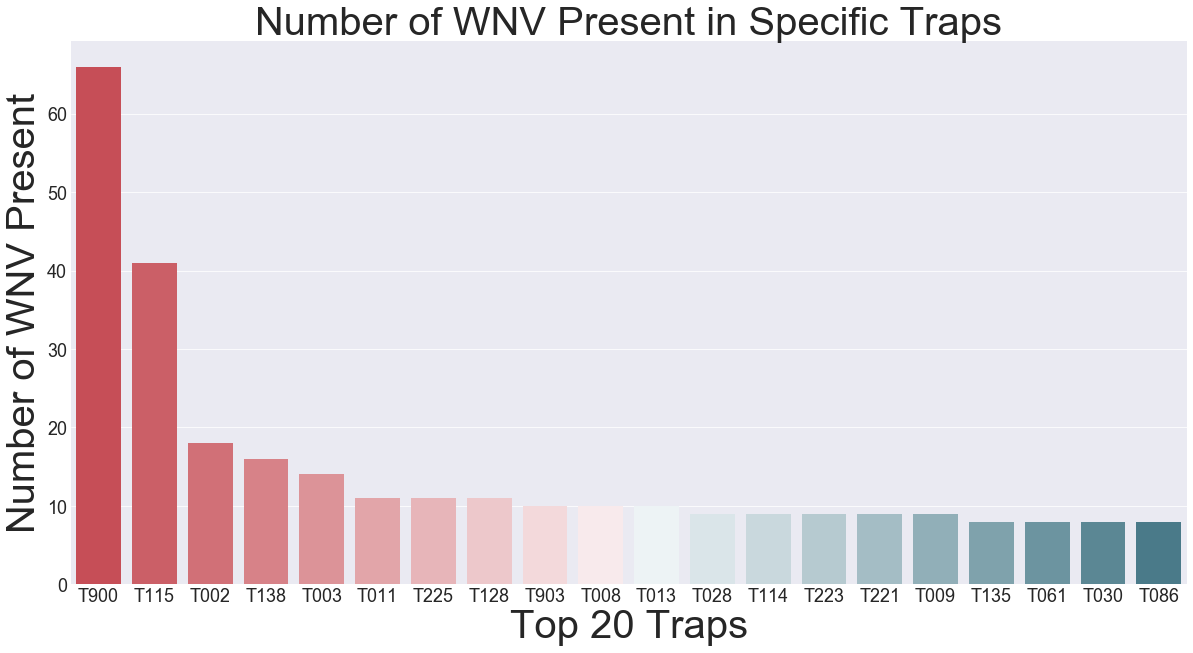

In [56]:
wnv_vs_trap_df = df.groupby(by='trap').sum()[['nummosquitos', 'wnvpresent']].sort_values(by='wnvpresent', 
                                                                                         ascending=False)
wnv_vs_traps_top20 = wnv_vs_trap_df.head(20)
wnv_vs_traps_top20.reset_index(inplace=True)

f, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=wnv_vs_traps_top20,
           x=wnv_vs_traps_top20.trap,
           y=wnv_vs_traps_top20.wnvpresent,
           ax=ax, palette=sns.diverging_palette(10, 220, n=20), );
ax.tick_params(labelsize=18)
ax.set_ylabel('Number of WNV Present', fontsize=40)
ax.set_xlabel('Top 20 Traps', fontsize=40)
ax.set_title('Number of WNV Present in Specific Traps', fontsize=40);

plt.savefig('../plots/num_of_mosquitoes_with_wnv_in_specific_traps.png')

# This plot shows that a majority of the mosquitoes with wnv present show up in trap T900 and T115

Text(0.5,1,'Number of Mosquitos vs. Result Speed')

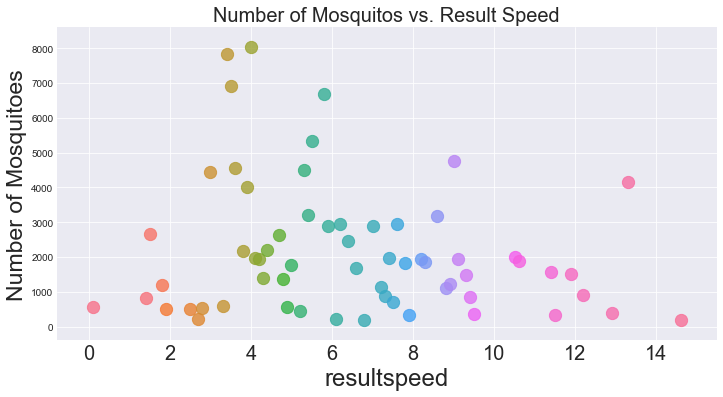

In [90]:
resultspeed_vs_nummosquitos_df = df[['resultspeed', 'nummosquitos']].groupby(by=['resultspeed']).sum()

resultspeed_vs_nummosquitos_df.reset_index(inplace=True)

sns.lmplot(data=resultspeed_vs_nummosquitos_df, y='nummosquitos', x='resultspeed', 
           hue='resultspeed', fit_reg=False,
          size=5, aspect=2, scatter_kws={"s": 150}, legend=False);

plt.xlabel('resultspeed', fontsize=24);
plt.ylabel('Number of Mosquitoes', fontsize=23);
plt.xticks(fontsize=20);
plt.title('Number of Mosquitos vs. Result Speed', fontsize=20);

plt.savefig('../plots/mosquitoes_vs_resultspeed_on_months_all_years.png')

# This plot shows the Result Speed vs the Number of Mosquitoes, you can see here at a speed of
# around 4, the number of mosquitoes tend to increase

In [101]:
df[['tavg_30', 'nummosquitos', 'year', 'month']].groupby(by=['year', 'month', 'tavg_30']).sum().tail()

nummosquitos
year month tavg_30                
2013 8     74.666667          2645
     9     64.833333           505
           70.966667          1030
           75.333333          2510
           75.933333          2210

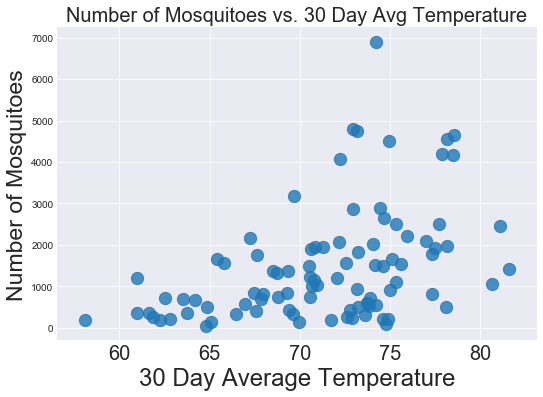

In [111]:
tavg_30_vs_nummosquitos_df = df[['tavg_30', 'nummosquitos', 'year', 'month']].groupby(
    by=['year', 'month', 'tavg_30']).sum()

tavg_30_vs_nummosquitos_df.reset_index(inplace=True)

sns.lmplot(data=tavg_30_vs_nummosquitos_df, y='nummosquitos', x='tavg_30', 
           #hue='month', 
           fit_reg=False, size=5, aspect=1.5, scatter_kws={"s": 150}, legend=False)

# plt.legend(['May', 'June', 'July', 'August', 'September', 'October'], loc='best', fontsize=20)
plt.xlabel('30 Day Average Temperature', fontsize=24)
plt.ylabel('Number of Mosquitoes', fontsize=23)
plt.xticks(fontsize=20)
plt.title('Number of Mosquitoes vs. 30 Day Avg Temperature', fontsize=20)

plt.savefig('../plots/mosquitoes_vs_tavg_30_on_months_all_years.png')

# This plot shows when the similar moving average of 30 dayss average temperature is in the 70s 
# the number of mosquitoes increases which increases the number of wnv present

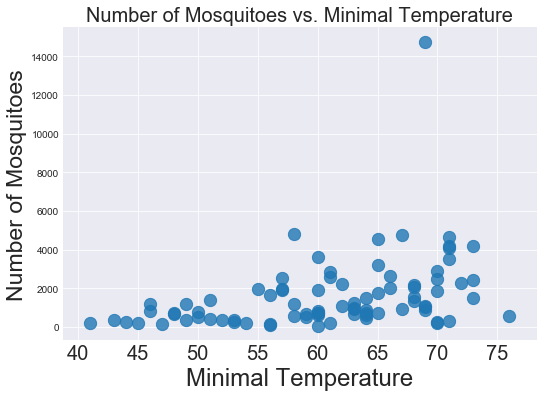

In [119]:
tmin_vs_nummosquitos_df = df[['tmin', 'nummosquitos', 'year', 'month']].groupby(
    by=['year', 'month', 'tmin']).sum()

tmin_vs_nummosquitos_df.reset_index(inplace=True)

sns.lmplot(data=tmin_vs_nummosquitos_df, y='nummosquitos', x='tmin', 
           #hue='month', 
           fit_reg=False, size=5, aspect=1.5, scatter_kws={"s": 150}, legend=False)

# plt.legend(['May', 'June', 'July', 'August', 'September', 'October'], loc='best', fontsize=20)
plt.xlabel('Minimal Temperature', fontsize=24)
plt.ylabel('Number of Mosquitoes', fontsize=23)
plt.xticks(fontsize=20)
plt.title('Number of Mosquitoes vs. Minimal Temperature', fontsize=20)

plt.savefig('../plots/mosquitoes_vs_tmin_on_months_all_years.png')

#This plot shows when the minimal temperature gets closer to 70F you can se an increase in mosquitoes

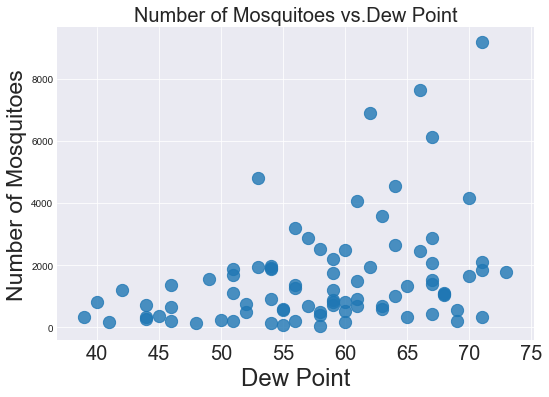

In [120]:
dewpoint_vs_nummosquitos_df = df[['dewpoint', 'nummosquitos', 'year', 'month']].groupby(
    by=['year', 'month', 'dewpoint']).sum()

dewpoint_vs_nummosquitos_df.reset_index(inplace=True)

sns.lmplot(data=dewpoint_vs_nummosquitos_df, y='nummosquitos', x='dewpoint', 
           #hue='month', 
           fit_reg=False, size=5, aspect=1.5, scatter_kws={"s": 150}, legend=False)

# plt.legend(['May', 'June', 'July', 'August', 'September', 'October'], loc='best', fontsize=20)
plt.xlabel('Dew Point', fontsize=24)
plt.ylabel('Number of Mosquitoes', fontsize=23)
plt.xticks(fontsize=20)
plt.title('Number of Mosquitoes vs.Dew Point', fontsize=20)

plt.savefig('../plots/mosquitoes_vs_dewpoint_on_months_all_years.png')

#This plot show that at a certain dew point range the number of mosquitoes also increases

In [116]:
df.groupby(by='month').mean()

,block,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,day,station,tmax,...,sq,tsra,gr,sn,br,fg+,fg,tavg_7,tavg_30,week
month,,,,,,,,,,,,,,,,,,,,,
5,36.869048,41.843323,-87.688444,7.928571,2.738095,0.000000,2008.404762,28.297619,1.0,69.738095,...,0.0,0.000000,0.0,0.0,0.297619,0.0,0.000000,63.452381,62.997222,22.000000
6,34.432341,41.867881,-87.727143,8.117050,10.676590,0.000677,2010.457375,17.421516,1.0,77.901218,...,0.0,0.145467,0.0,0.0,0.376184,0.0,0.000000,68.749468,67.560510,24.584574
7,36.267076,41.849897,-87.707956,7.900614,14.293170,0.017652,2010.026094,17.954720,1.0,83.778972,...,0.0,0.130852,0.0,0.0,0.302763,0.0,0.000000,75.490187,74.941085,29.020338
8,35.328179,41.823170,-87.683934,7.645694,15.472141,0.100507,2009.059184,13.154625,1.0,84.188750,...,0.0,0.191949,0.0,0.0,0.309251,0.0,0.000000,74.763111,74.669519,32.681418
9,36.009468,41.842378,-87.700060,7.790803,9.481064,0.056357,2009.665464,15.086114,1.0,79.260595,...,0.0,0.050496,0.0,0.0,0.148332,0.0,0.050496,68.489244,69.467268,37.431019
10,37.452899,41.837669,-87.692552,7.884058,6.949275,0.007246,2007.471014,3.764493,1.0,76.018116,...,0.0,0.000000,0.0,0.0,0.235507,0.0,0.000000,64.198240,67.286715,40.094203


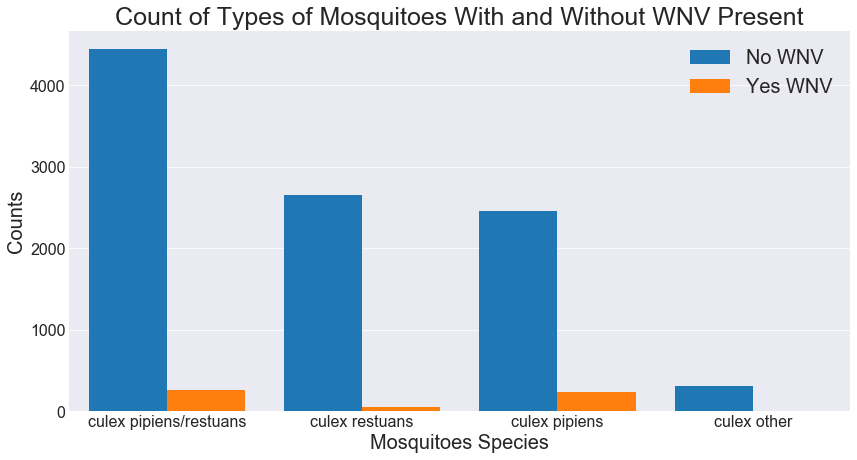

In [179]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.countplot(data=df, x='species', hue = 'wnvpresent', saturation=1)
ax.tick_params(labelsize=16)
plt.legend(['No WNV', 'Yes WNV'], loc='upper right', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.set_xlabel('Mosquitoes Species', fontsize=20)
ax.set_title('Count of Types of Mosquitoes With and Without WNV Present', fontsize=25);

plt.savefig('../plots/mosquitoes_species_counts__species_w_and_wo_wnv.png')

#This plot shows that WNV only shows up on the 2 types of mosquitoes or a blend of that type

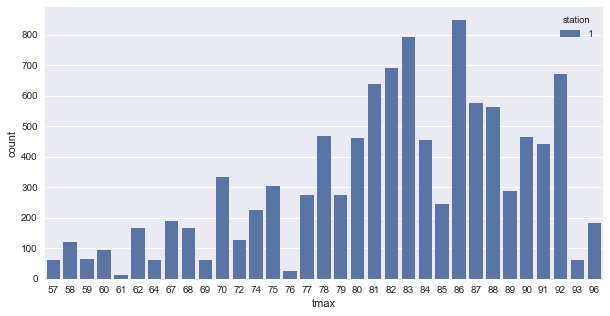

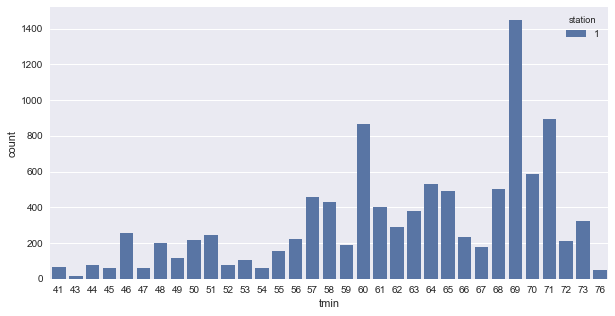

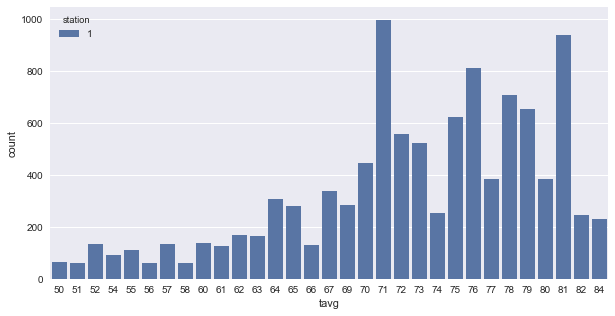

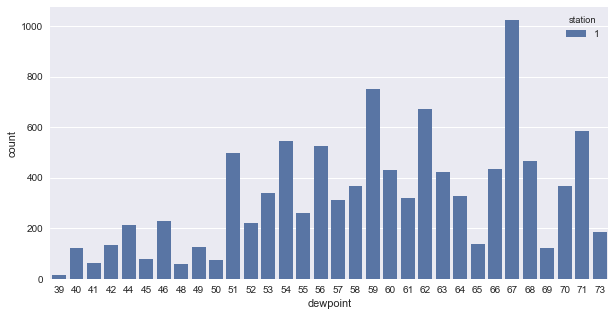

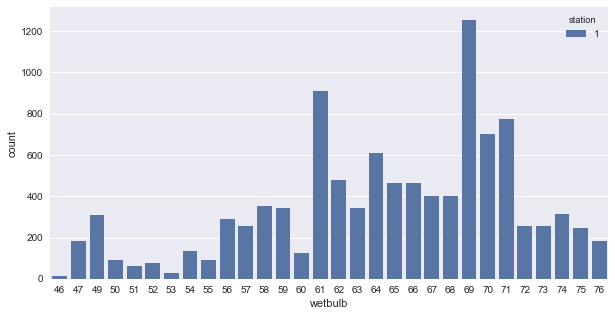

In [194]:
# Here we want to plot some of the weather data to see 
to_plot = ['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb']
for item in to_plot:
    sns.set(font_scale=1)
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    sns.countplot(x = item,  data = df, hue = 'station')

This concludes the visuals for looking at the features vs the wnv present and mosquitoes count